In [1]:
from tqdm import tqdm
import mediapipe as mp
import os
import shutil
import json
import time
from util.sound_processing import *
from util.ioUtil import *
import numpy as np
from scipy.spatial.transform import Rotation
from matplotlib import pyplot as plt
import parselmouth
from IPython.display import Audio

In [2]:
snd = parselmouth.Sound("/Volumes/EVAN_DISK/ten_videos/Child_in_time/Child_in_time_2/audio.mp3")
time_step = 0.01 # pitch estimated at 100 Hz, not bad 
pitch_ceiling = 1000
pitch = snd.to_pitch(time_step = time_step, pitch_ceiling = pitch_ceiling)

In [3]:
def draw_intensity(intensity):
    plt.plot(intensity.xs(), intensity.values.T, linewidth=3, color='w')
    plt.plot(intensity.xs(), intensity.values.T, linewidth=1)
    plt.grid(False)
    plt.ylim(0)
    plt.ylabel("intensity [dB]")
def draw_pitch(pitch):
    # Extract selected pitch contour, and
    # replace unvoiced samples by NaN to not plot
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, pitch.ceiling)
    plt.ylabel("fundamental frequency [Hz]")
    
# upper_lip_top = 0
def get_lip_shapes(mp_arr):
    upper_lip_bottom = 13
    lower_lip_top = 14
    # lower_lip_bottom = 17
    left_lip = 292
    right_lip = 62

    lip_parameters = [upper_lip_bottom, lower_lip_top, left_lip, right_lip]
    vertical_openning = np.linalg.norm(mp_arr[:,lip_parameters[0]] - mp_arr[:,lip_parameters[1]], axis=1)
    vertical_openning = (vertical_openning - vertical_openning.min())/(vertical_openning.max() - vertical_openning.min())
    horizontal_openning = np.linalg.norm(mp_arr[:,lip_parameters[2]] - mp_arr[:,lip_parameters[3]], axis=1)
    horizontal_openning = (horizontal_openning - horizontal_openning.min())/(horizontal_openning.max() - horizontal_openning.min())
    return [vertical_openning, horizontal_openning]
def get_subarray_from_time_interval(interval, xs, ys):
    x_vals_low = [-1, -1]
    for i in range(0, xs.shape[0]):
#         x_vals_low.append(xs[i])
        if xs[i] >= interval[0]:
            x_vals_low[0] = i
            break
    for i in range(0, xs.shape[0]):
#         x_vals_low.append(xs[i])
        if xs[i] <= interval[1] and x_vals_low[0] != -1:
            x_vals_low[1] = i
    new_xs = xs[x_vals_low[0]:x_vals_low[1]]
    new_ys = ys[x_vals_low[0]:x_vals_low[1]]
    return new_xs, new_ys

In [4]:
landmarks_path = "/Volumes/EVAN_DISK/ten_videos/Child_in_time/Child_in_time_2/mediapipe_landmark.npy"
land_marks = np.load(landmarks_path)
v_arr, h_arr = get_lip_shapes(land_marks)

29.97002997002997


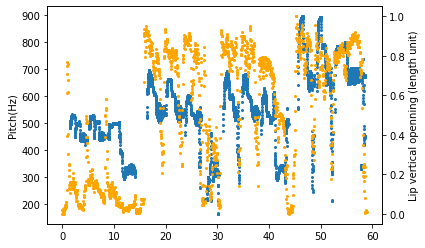

In [5]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()

pitch_values = pitch.selected_array['frequency']
pitch_values[pitch_values>=1000] = np.nan
pitch_values[pitch_values==0] = np.nan
ax_left.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
ax_left.plot(pitch.xs(), pitch_values, 'o', markersize=2)
ax_left.set_ylabel("Pitch(Hz)")
ax_right.set_ylabel("Lip vertical openning (length unit)")
ax_left.grid(False)
# plt.ylim(0, pitch.ceiling)
with open("/Volumes/EVAN_DISK/ten_videos/Child_in_time/Child_in_time_2/other_info.json") as f:
    fps_video = json.load(f)["fps"]
print(fps_video)
time = 0;
lip_xs = []
for i in range(0, len(v_arr)):
    time = time + 1/fps_video
    lip_xs.append(time)

# ax_left.plot(left_data, color='black')
ax_right.plot(np.array(lip_xs), v_arr, 'o', markersize=2, color = "orange")

# De-noise the pitch prediction

In [6]:
pitch = snd.to_pitch(time_step = time_step, pitch_ceiling = 1000)

strength = pitch.selected_array["strength"]
frequency = pitch.selected_array["frequency"]

In [7]:
frequency[strength < 0.5] = 0
frequency[frequency==0] = np.nan

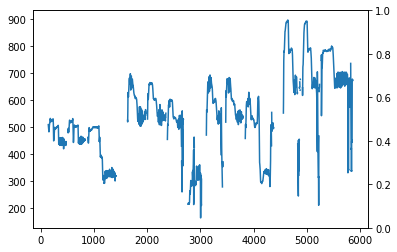

In [8]:
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.plot(frequency)

### Savgol filter testing

In [9]:
from scipy.signal import savgol_filter, correlate

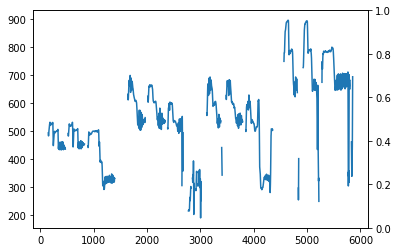

In [10]:
smoothed_pitch = savgol_filter(frequency, 15, 5)
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.plot(smoothed_pitch)

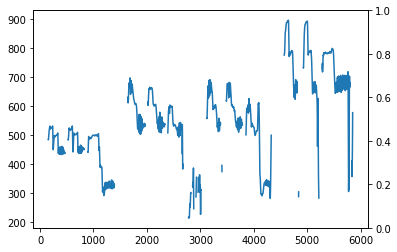

In [11]:
smoothed_pitch = savgol_filter(frequency, 21,5) # 21 time steps corresponds to 1 second, we assume 5 inflection in a second
fig, ax_left = plt.subplots()
ax_right = ax_left.twinx()
ax_left.plot(smoothed_pitch)

### Obtain the interval where the vibrato happens using zero crossing

In [12]:
frequency.shape

(5888,)

In [13]:
dt = pitch.xs()[1] - pitch.xs()[0]
frequency_xs = pitch.xs()
d_frequency_dt = correlate(frequency, np.array([-1.0, 0, 1.0]), mode="same")/dt/2

min_zero_crossing_distance = 1.0/14 # max vibrato frequency = 7 Hz = 14 zero crossings per second
tolerance = dt * 2.5 # using the uncertainty of the instrument (pitch measuring device) to bound tolerance

zero_crossing = []
for i in range(0, d_frequency_dt.shape[0]-1):
    if (d_frequency_dt[i] < 0 and d_frequency_dt[i+1] >= 0) or (d_frequency_dt[i] > 0 and d_frequency_dt[i+1] <= 0):
        zero_crossing.append(i+1)
distance = 0
in_vibrato = 0
starting_time = -1
ending_time = -1

vibrato_intervals = []
for i in range(0, len(zero_crossing)-1):
    current_distance = frequency_xs[zero_crossing[i+1]] - frequency_xs[zero_crossing[i]]
    
    if abs(current_distance - distance) <= tolerance and current_distance >= min_zero_crossing_distance:
        if in_vibrato == 0:
            starting_time = zero_crossing[i-1]
            distance = (distance + current_distance) / 2 # calculate new average
            in_vibrato = 1
        elif in_vibrato > 0:
            distance = (distance * in_vibrato + current_distance) / (in_vibrato + 1) # calculate new average
            in_vibrato = in_vibrato + 1
    else:
        if in_vibrato > 0:
            distance = current_distance
            if in_vibrato > 2:
                vibrato_intervals.append([frequency_xs[starting_time], frequency_xs[zero_crossing[i]]])
            in_vibrato = 0
        else:
            distance = current_distance

In [14]:
### store the intensity values in textgrid
import textgrids

### this do not have to be included in the function
output_path = "E:/Speech_data_set/alignment_test"
new_grid = textgrids.TextGrid() # initialize new_textgrid object
new_grid.xmin = 0
new_grid.xmax = frequency_xs[-1]
### this do not have to be included in the function
print(new_grid)
new_grid["vibrato"] = textgrids.Tier()
for i in range(0, len(vibrato_intervals)):
    interval = textgrids.Interval("vibrato", vibrato_intervals[i][0], vibrato_intervals[i][1])
    new_grid["vibrato"].append(interval)
# new_grid.write(output_path + "/child_in_time_2_vibrato.TextGrid")

File type = "ooTextFile"
Object class = "TextGrid"

xmin = 0
xmax = 58.89403628117914
tiers? <exists>
size = 0
item []:


In [15]:
new_grid

File type = "ooTextFile"
Object class = "TextGrid"

xmin = 0
xmax = 58.89403628117914
tiers? <exists>
size = 1
item []:
    item [1]:
        class = "IntervalTier"
        name = "vibrato"
        xmin = 0
        xmax = 58.89403628117914
        intervals: size = 11
            intervals [1]:
                xmin = 3.2240362811791368
                xmax = 4.294036281179137
                text = "vibrato"
            intervals [2]:
                xmin = 7.024036281179137
                xmax = 7.824036281179136
                text = "vibrato"
            intervals [3]:
                xmin = 12.034036281179137
                xmax = 13.904036281179138
                text = "vibrato"
            intervals [4]:
                xmin = 18.304036281179137
                xmax = 18.964036281179137
                text = "vibrato"
            intervals [5]:
                xmin = 21.994036281179135
                xmax = 22.824036281179136
                text = "vibrato"
            in

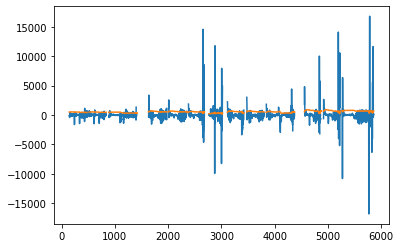

In [16]:
plt.plot(d_frequency_dt)
plt.plot(frequency)

In [17]:
x, y = get_subarray_from_time_interval([3.3, 4.3], pitch.xs(), d_frequency_dt)

Text(0, 0.5, 'df/dt')

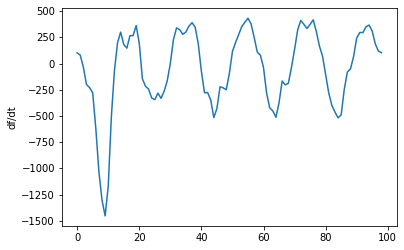

In [18]:
plt.plot(y)
plt.ylabel("df/dt")

# Formant Analysis of Belting vs Head voice

In [19]:
from scipy.interpolate import interp1d
snd = parselmouth.Sound("/Volumes/EVAN_DISK/ten_videos/rolling_in_the_deep/rolling_in_the_deep_2/audio_vocals.wav")

In [20]:
formant = snd.to_formant_burg(time_step = dt)
pitch = snd.to_pitch(time_step = time_step, pitch_ceiling = 1000)
strength = pitch.selected_array["strength"]
frequency = pitch.selected_array["frequency"]
print(strength.shape)

(1995,)


In [21]:
# print(formant.get_value_at_time(1, 0.2))
# print(formant.get_bandwidth_at_time(1, 0.2))
xs = formant.xs()
formant_arr = np.zeros((len(xs), 3))
for i in range(0, formant_arr.shape[0]):
    for j in range(1, 4):
        formant_arr[i, j-1] = formant.get_value_at_time(j, xs[i])

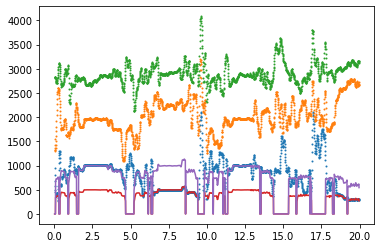

In [22]:
smooth_formant_arr = np.zeros(formant_arr.shape)
for i in range(0, 3):
    smooth_formant_arr[:, i] = savgol_filter(formant_arr[:, i], 21, 3)
for i in range(0, 3):
    plt.plot(formant.xs(), smooth_formant_arr[:, i], "o", markersize=1)

formant_1_2_distance = smooth_formant_arr[:, 1] - smooth_formant_arr[:, 0]
plt.plot(pitch.xs(), frequency)
plt.plot(pitch.xs(), frequency * 2)

In [23]:
H2_F1 = np.abs(frequency * 2 - smooth_formant_arr[:, 0])
f = interp1d(xs, H2_F1)

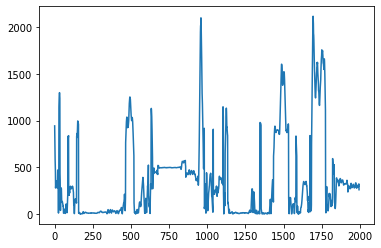

In [24]:
plt.plot(H2_F1)

In [167]:
phoneme_alignment = textgrids.TextGrid("/Volumes/EVAN_DISK/alignment_test/alignment_output/rolling_in_the_deep_2_for_killian.TextGrid")

In [168]:
VOWELS = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH',
                      'EY', 'IH', 'IY', 'OW', 'OY',
                      'UH', 'UW'])
belting_intervals = []
head_voice_intervals = []
for item in phoneme_alignment["phones"]:
    if item.text in VOWELS:
        vowel_span = np.arange(item.xmin, item.xmax, dt)
        H2_F1_i = f(vowel_span)
        if H2_F1_i.mean() <= 50:
            belting_intervals.append([item.xmin, item.xmax])
        else:
            head_voice_intervals.append([item.xmin, item.xmax])

In [169]:
phoneme_alignment["phones"][0]

<Interval text="W" xmin=0.08 xmax=0.112>

In [170]:
phoneme_alignment["voice_quality"] = textgrids.Tier()
for item in belting_intervals:
    interval = textgrids.Interval("belt", item[0], item[1])
    phoneme_alignment["voice_quality"].append(interval)
for item in head_voice_intervals:
    interval = textgrids.Interval("head", item[0], item[1])
    phoneme_alignment["voice_quality"].append(interval)
phoneme_alignment.write("E:/alignment_test/alignment_output" + "/rolling_in_the_deep_2_voice_quality.TextGrid")

# combine vocal ranges with vocal quality prediction

In [171]:
from util.sound_processing import Music_note

In [172]:
male_Tenor_Vocal_range = {"Chest":["C3", "G3"], "Middle":["G3", "G4"], "Head":["G4", "C5"], "Falsetto":["C5", "F5"],
                    "Lower Middle":["G3", "D4"], "Upper Middle":["D4", "G4"]}
female_Sopreno_Vocal_range = {"Chest":["G3", "E4"], "Middle":["E4", "F5"], "Head":["F5", "C6"], "Falsetto":["C6", "C7"],
                    "Lower Middle":["G3", "D4"], "Upper Middle":["D4", "G4"]}

vocal_register_list_tier_1 = ["Chest", "Middle", "Head", "Falsetto"]
vocal_register_list_tier_2 = ["Lower Middle", "Upper Middle"]
print(Music_note.note2freq("C7"))

2093.004522404789


G#5


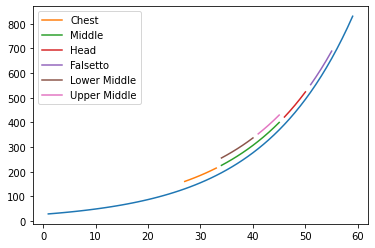

In [173]:
from util.sound_processing import Music_note, PraatScript_Lyric_Wrapper
x = np.arange(1, 60)
lowest_note = 27.5
y = lowest_note * pow(2, x/12)
print(Music_note.freq2note(y[-1]))
plt.plot(x, y)
for reg in vocal_register_list_tier_1:
    note_lo = Music_note.note2freq(male_Tenor_Vocal_range[reg][0])
    note_hi = Music_note.note2freq(male_Tenor_Vocal_range[reg][1])
    x_lo = np.log2(note_lo/lowest_note) * 12
    x_hi = np.log2(note_hi/lowest_note) * 12
    x_range = np.arange(x_lo, x_hi)
    note_range = lowest_note * pow(2, x_range/12)
    plt.plot(x_range, note_range + 30, label=reg)
for reg in vocal_register_list_tier_2:
    note_lo = Music_note.note2freq(male_Tenor_Vocal_range[reg][0])
    note_hi = Music_note.note2freq(male_Tenor_Vocal_range[reg][1])
    x_lo = np.log2(note_lo/lowest_note) * 12
    x_hi = np.log2(note_hi/lowest_note) * 12
    x_range = np.arange(x_lo, x_hi)
    note_range = lowest_note * pow(2, x_range/12)
    plt.plot(x_range, note_range + 60, label=reg)
plt.legend()

In [174]:
print(Music_note.note2freq("C6"))

1046.5022612023945


### Using SubHarmonic to Harmonic Ratio to determine Falsetto

In [3]:
audio_path_file = "E:/alignment_test/falsetto/Male_falsetto.wav"
sound = parselmouth.Sound(audio_path_file)

In [4]:
dt = 0.01
spectrogram = sound.to_spectrogram(time_step = dt)

In [5]:
spectrogram.get_power_at(0.2, 500)
pitch = sound.to_pitch()
freq = pitch.selected_array["frequency"]
xs = sound.to_pitch().xs()

print(xs.shape)
H2_H1 = np.zeros(xs.shape)
for i in range(0, xs.shape[0]):
    H2_H1[i] = spectrogram.get_power_at(xs[i], freq[i] * 2) - spectrogram.get_power_at(xs[i], freq[i])        

(1825,)


In [6]:
from scipy.signal import correlate
from scipy.signal.windows import gaussian
sigma = 10
smoothed_H2_H1 = correlate(H2_H1, gaussian(sigma*4, sigma), mode="same")

Positive H2-H1 value seems to indicate falsetto, and vice-versa 

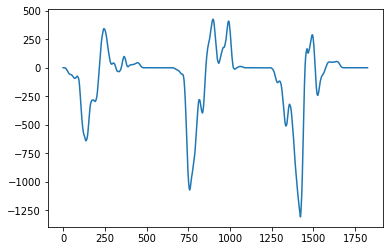

In [7]:
plt.plot(smoothed_H2_H1)

### testing out some added praatscript_lyric_wrapper functions

In [8]:
# from util.sound_processing import create_lyric_alignment_textgrids, PraatScript_Lyric_Wrapper

# dir = "E:/Structured_data/cry_me_a_river_ella_fitzgerald"
# file_name_template = "audio_1"

# textgrid_path, sentences =  create_lyric_alignment_textgrids(dir, file_name_template)

### Identify Different audio features from song lyrics. Using phoneme alignment data to expedite the process

In [9]:
from util.sound_processing import *

dir = "E:/Structured_data/cry_me_a_river_ella_fitzgerald"
file_name_template = "audio_1"
aligned_audio = combine_lyric_alignment_textgrids(dir, file_name_template)

In [10]:
aligned_audio.compute_self_vibrato_intervals()
freq = aligned_audio.pitch.selected_array["frequency"]
phoneme_list = aligned_audio.phoneme_list
phoneme_intervals = aligned_audio.phoneme_intervals

In [11]:
def get_subarrays_indexes_from_time_interval(intervals, xs): 
    # here i'm assuming that all interval in intervals have [t0, t1] where t0 < t1
    x_vals_low = [-1, -1]
    index_intervals = []
    # iterate through the intervals 
    search_pointer = 0
    for interval in intervals:
        # find the start of the interval
        index_interval = [-1, -1]
        for i in range(search_pointer, xs.shape[0]):
            if xs[i] >= interval[0]:
                index_interval[0] = i
                search_pointer = i
                break
        for i in range(search_pointer, xs.shape[0]):
            if xs[i] >= interval[1]:
                index_interval[1] = i-1
                search_pointer = i-1
                break
        index_intervals.append(index_interval)
    return index_intervals

### Vibrato

In [12]:
from scipy.interpolate import interp1d

VOWELS = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW', "ER"])
freq = aligned_audio.pitch.selected_array["frequency"]
xs = aligned_audio.pitch.xs()
phoneme_interval_index = get_subarrays_indexes_from_time_interval(phoneme_intervals, xs)
# smooth frequency so it does not have sudden jumps during silence
freq[freq==0] = np.nan
# use interpolation to deal with missing value in the pitch prediction
f = interp1d(xs, freq)

In [13]:
def compute_vibrato_intervals(self, frequency, frequency_xs, dt):
    # this function computes vibrato by analyzing the zero-crossing of the input frequency array
    # if it can identify 3 zero crossing that are equally spaced apart, then it recognize those
    # as a vibrato.
    min_zero_crossing_distance = 1.0 / 16  # max vibrato frequency = 7 Hz = 14 zero crossings per second
    self.tolerance = dt * 5  # using the uncertainty of the instrument (pitch measuring device) to bound tolerance
    # compute time derivative
    d_frequency_dt = correlate(frequency, np.array([-1.0, 0, 1.0]), mode="same") / dt / 2
    # obtain zero crossings
    zero_crossing = []
    for i in range(0, d_frequency_dt.shape[0] - 1):
        if (d_frequency_dt[i] < 0 and d_frequency_dt[i + 1] >= 0) or (
                d_frequency_dt[i] > 0 and d_frequency_dt[i + 1] <= 0):
            zero_crossing.append(i + 1)

    # choose sets of zero crossing and identify vibratos within those
    distance = 0
    in_vibrato = 0
    starting_time = -1
    vibrato_intervals = []
    for i in range(0, len(zero_crossing) - 1):
        current_distance = frequency_xs[zero_crossing[i + 1]] - frequency_xs[zero_crossing[i]]
#         print(in_vibrato, current_distance, distance)
        
        if abs(current_distance - distance) <= self.tolerance and current_distance >= min_zero_crossing_distance:
            if in_vibrato == 0:
                starting_time = zero_crossing[i - 1]
                distance = (distance + current_distance) / 2  # calculate new average
                in_vibrato = 1
            elif in_vibrato > 0:
                distance = (distance * in_vibrato + current_distance) / (in_vibrato + 1)  # calculate new average
                in_vibrato = in_vibrato + 1
        else:
            if in_vibrato > 0:
                distance = current_distance
                if in_vibrato > 2:
                    vibrato_intervals.append([frequency_xs[starting_time], frequency_xs[zero_crossing[i]]])
                in_vibrato = 0
            else:
                distance = current_distance
    return vibrato_intervals

### pitchs

In [14]:
VOWELS = set(['AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'EH', 'EY', 'IH', 'IY', 'OW', 'OY', 'UH', 'UW', "ER"])
freq = aligned_audio.pitch.selected_array["frequency"]
xs = aligned_audio.pitch.xs()
phoneme_interval_index = get_subarrays_indexes_from_time_interval(phoneme_intervals, xs)
# smooth frequency so it does not have sudden jumps during silence
freq[freq==0] = np.nan
# use interpolation to deal with missing value in the pitch prediction
f = interp1d(xs, freq, kind="linear")

In [15]:
import numpy as np
from scipy.signal import savgol_filter, convolve
from scipy.signal.windows import gaussian

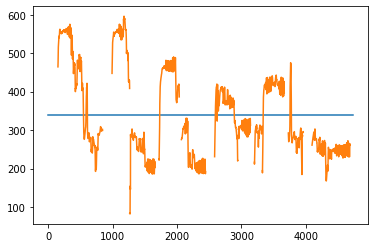

In [16]:
q = np.nanpercentile(freq, [2, 98])
passagio = q[0] + 0.4 * (q[1] - q[0])
plt.plot([0, freq.shape[0]], [passagio, passagio])
plt.plot(freq)

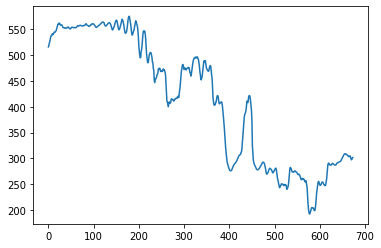

In [17]:
sub_intervals = get_subarrays_indexes_from_time_interval(phoneme_intervals, xs)
LOWEST_NOTE = 27.5
sigma = 10 # smoothing around the 0.1 second neighbourhood
window = 1/np.sqrt(np.pi * 2) / sigma * gaussian(sigma * 4, sigma)
window_short = 1/np.sqrt(np.pi * 2) / sigma * gaussian(sigma * 2, sigma)
 

pitch_feature_list = []
pitch_feature_intervals = []
for i in range(0, len(sub_intervals)):
    interval = sub_intervals[i]
    phone = phoneme_list[i]
    pitch_feature_per_vowel = []
    pitch_feature_intervals_per_vowel = []
    
    if phone in VOWELS:
        xs_interval = xs[interval[0]:interval[1]]
        freq_interval = f(xs_interval)
        plt.plot(freq_interval)
        break
        
        smoothed_freq = convolve(padded_freq_interval, window, mode="same")[sigma*2:-sigma*2]
        speed = convolve(np.pad(smoothed_freq, [1,1], mode = "edge"), np.array([-1,0,1]), mode="same")[1:-1]/aligned_audio.dt
        speed = np.abs(12 * np.log2(speed))
        plt.plot(speed)
        interval_length = xs[interval[1]] - xs[interval[0]]
        if interval_length <= 0.5:
            padded_freq_interval = np.pad(freq_interval, [sigma, sigma], mode = "constant", constant_values = [
            freq_interval[:sigma*2].mean(), freq_interval[sigma:].mean()])
            smoothed_freq = convolve(padded_freq_interval, window_short, mode="same")[sigma:-sigma]
            interval_pitch = max(smoothed_freq[-1], smoothed_freq[-0])
            pitch_feature_per_vowel.append("constant-")

            
    # append the feature to the list
    pitch_feature_list.append(pitch_feature_per_vowel)
    pitch_feature_intervals.append(pitch_feature_intervals_per_vowel)
        

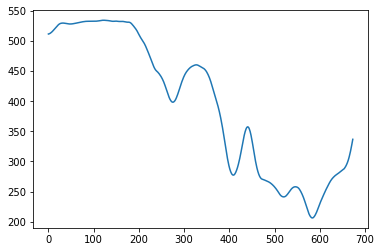

In [27]:
# setting up window function for smoothing
sigma = 10 # smoothing around the 0.1 second neighbourhood
window = 1/np.sqrt(np.pi * 2) / sigma * gaussian(sigma * 4, sigma)
window_short = 1/np.sqrt(np.pi * 2) / sigma * gaussian(sigma * 2, sigma)

# this is the interval with the first long vowel
interval = sub_intervals[2]
xs_interval = xs[interval[0]:interval[1]]
freq_interval = f(xs_interval)
padded_freq_interval = np.pad(freq_interval, [sigma*2, sigma*2], mode = "constant", constant_values = [
freq_interval[:sigma*2].mean(), freq_interval[sigma:].mean()])
smoothed_freq = convolve(padded_freq_interval, window, mode="same")[sigma*2:-sigma*2]
plt.plot(smoothed_freq)


In [140]:
def compute_cost(a, b, x, y, E_line = 0.1):
    # a and b are indexes into array x and y
    # x is the horizontal axis, y is the vertical
    cost = E_line
    slope = (y[b] - y[a])/(x[b] - x[a])
    y_int = y[b] - slope*x[b]
    real_y = y[a:b]
    vertical_difference = real_y - (y_int + slope * x[a:b])
    vertical_difference = np.linalg.norm(vertical_difference, ord=1)
    cost = cost + vertical_difference
    return cost
def traverse_solution(back_track):
    queue = [[0, back_track.shape[0]-1]]
    sol = []
    while len(queue) > 0:
        current = queue.pop(0)
        current_pointer = int(back_track[current[0], current[1]])
        if current_pointer == -1:
            sol.append([current[0], current[1]])
        else:
            queue = [[current[0], current_pointer],[current_pointer, current[1]]] + queue
    return sol
def piece_wise_linear_intervals(x, y, E_line = 400):
    M = np.zeros((y.shape[0], y.shape[0]))
    back_track = np.zeros((y.shape[0], y.shape[0]))
    for i in range(1, y.shape[0]):
        # for each diagonal
        diagona_size = y.shape[0] - i
        diag_i = np.zeros((diagona_size, ))
        for a in range(0, diagona_size):
            # for each element in the diagonal
            diag_i[a] = compute_cost(a, i+a, x, y, E_line)
            back_track[a,a+i] = -1
            # iterate through the precomputed matrix
            for k in range(1, i):
                combined_cost = M[a, a+i-k] + M[a+(i-k), a+i]
                if combined_cost < diag_i[a]: 
                    diag_i[a] = combined_cost
                    back_track[a, a+i] = a+i-k
        M = M + np.diag(diag_i, i)
        
    # M is the value matrix, backtrack is the matrix that contains the solution
    return traverse_solution(back_track)
    

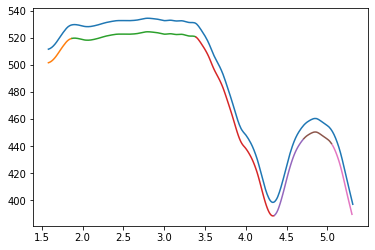

In [149]:
x = xs[interval[0]:interval[1]][:-300]
y = smoothed_freq[:-300]
sol = piece_wise_linear_intervals(x,y,400)
plt.plot(x, y)
for i in range(0, len(sol)):
    plt.plot(x[sol[i][0]:sol[i][1]], y[sol[i][0]:sol[i][1]] - 10)

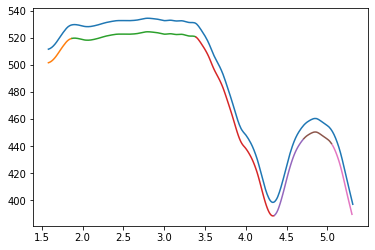

In [150]:
x = xs[interval[0]:interval[1]][:-300]
y = smoothed_freq[:-300]
sol = piece_wise_linear_intervals(x,y,600)
plt.plot(x, y)
for i in range(0, len(sol)):
    plt.plot(x[sol[i][0]:sol[i][1]], y[sol[i][0]:sol[i][1]] - 10)

### Use engineering to break down the pitch estimation to run faster!

In [222]:
# input
# interval, xs, frequency, phoneme_intervals
freq = aligned_audio.pitch.selected_array["frequency"]
xs = aligned_audio.pitch.xs()
phoneme_interval_index = get_subarrays_indexes_from_time_interval(phoneme_intervals, xs)
# smooth frequency so it does not have sudden jumps during silence
freq[freq==0] = np.nan
# use interpolation to deal with missing value in the pitch prediction
f = interp1d(xs, freq, kind="linear")
xs_interval = xs[interval[0]:interval[1]]
freq_interval = f(xs_interval)
padded_freq_interval = np.pad(freq_interval, [sigma*2, sigma*2], mode = "constant", constant_values = [
freq_interval[:sigma*2].mean(), freq_interval[sigma:].mean()])
smoothed_freq = convolve(padded_freq_interval, window, mode="same")[sigma*2:-sigma*2]

x = xs[interval[0]:interval[1]]
y = f(x)

In [227]:
L = 200

# divide the input to shorter subarrays
sub_x_lists = []
sub_y_lists = []
for i in range(0, int(np.ceil(x.shape[0]/L))):
    sub_x_lists.append(x[int(i*L):int(min((i+1)*L, x.shape[0]))])
    sub_y_lists.append(y[int(i*L):int(min((i+1)*L, x.shape[0]))])

# use dynamic programming to get linear intervals
pitch_intervals_index = []
for i in range(0, len(sub_x_lists)):
    sol_index = piece_wise_linear_intervals(sub_x_lists[i], sub_y_lists[i], 600)
    sol_index = [[val[0] + int(i * L), val[1] + int(i * L)] for val in sol_index]
    sol = [[x[val[0]], x[val[1]]] for val in sol_index]
    pitch_intervals_index = pitch_intervals_index + sol_index
for i in range(0, len(pitch_intervals_index) - 1):
    if pitch_intervals_index[i][1] < pitch_intervals_index[i+1][0]:
        pitch_intervals_index[i][1] = pitch_intervals_index[i+1][0]

# obtain the slope of these intervals
pitch_intervals_slopes = []
for i in range(0, len(pitch_intervals_index)):
    interval_i_index = pitch_intervals_index[i]
    slope = (y[interval_i_index[1]] - y[interval_i_index[0]])/(x[interval_i_index[1]] - x[interval_i_index[0]])
    pitch_intervals_slopes.append(slope)
    
# merge nearby intervals
pitch_intervals = []
pitch_slope = []
prev_begin = 0
prev_slope = pitch_intervals_slopes[0]
counting = 1
for i in range(1, len(pitch_intervals_slopes)):
    current_slope = pitch_intervals_slopes[i]
    if abs(current_slope - prev_slope) <= 30:
        prev_slope = ((prev_slope * counting) + current_slope)/(counting + 1)
        counting = counting + 1 
        if i == len(pitch_intervals_slopes)-1:
            pitch_intervals.append([prev_begin, pitch_intervals_index[i][1]])
            pitch_slope.append(prev_slope)
    else:
        if counting > 1:
            pitch_intervals.append([prev_begin, pitch_intervals_index[i-1][1]])
            pitch_slope.append(prev_slope)
        else:
            pitch_intervals.append([pitch_intervals_index[i-1][0], pitch_intervals_index[i-1][1]])
            pitch_slope.append(prev_slope)
        prev_slope = current_slope
        counting = 1
        prev_begin = pitch_intervals_index[i][0]
        if i == len(pitch_intervals_slopes)-1:
            pitch_intervals.append([prev_begin, pitch_intervals_index[i][1]])
            pitch_slope.append(prev_slope) 
pitch_slope = [0 if abs(val) < 15 else val for val in pitch_slope]

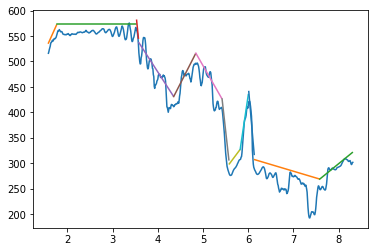

In [228]:
plt.plot(x, y)
for i in range(0, len(pitch_intervals)):
    plt.plot(x[pitch_intervals[i][0]:pitch_intervals[i][1]], 
         20 + (x[pitch_intervals[i][0]:pitch_intervals[i][1]] - x[pitch_intervals[i][0]]) * pitch_slope[i] + y[pitch_intervals[i][0]])
    

[62.044423556467365, 1.089323769337851, -92.27537784442478, -151.83961172291083, 131.11131848838315, -59.1212604211642, -340.97155372240127, 145.56087765515264, -326.2366042402905, -33.0297679880426, 146.82447886520927]


In [210]:
for i in range(0, len(pitch_intervals_slopes)):
    print(pitch_intervals_index[i], "\t" , pitch_intervals_slopes[i])

[0, 29] 	 62.044423556467365
[29, 178] 	 1.089323769337851
[178, 200] 	 -92.27537784442478
[200, 274] 	 -151.83961172291083
[274, 320] 	 131.11131848838315
[320, 357] 	 -59.1212604211642
[357, 400] 	 -340.97155372240127
[400, 444] 	 145.56087765515264
[444, 469] 	 -326.2366042402905
[469, 600] 	 -33.0297679880426
[600, 673] 	 146.82447886520927


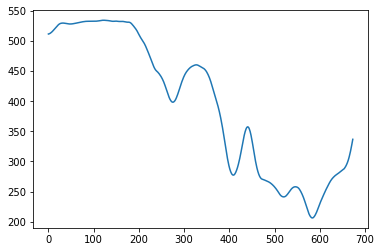

In [204]:
plt.plot(y)

In [211]:
# pitch_intervals_index
# pitch_intervals_slopes
# pitch_intervals_y_int


In [212]:
print(pitch_intervals_index)
print(pitch_intervals)

[[0, 29], [29, 178], [178, 200], [200, 274], [274, 320], [320, 357], [357, 400], [400, 444], [444, 469], [469, 600], [600, 673]]
[[0, 29], [29, 178], [178, 200], [200, 274], [274, 320], [320, 357], [357, 400], [400, 444], [444, 469], [469, 600], [600, 673]]


### Anneal the intervals at the boundaries

In [170]:
pitch_intervals_annealed = [pitch_intervals_raw[0][0]]
if len(pitch_intervals_raw[0]) == 1:
    pitch_intervals_annealed = []
for i in range(0, len(pitch_intervals_raw) - 1):
    # for each L-frame interval
    for k in range(1, len(pitch_intervals_raw[i])-1):
        pitch_intervals_annealed.append(pitch_intervals_raw[i][k])
    x_boundary_interval = x[pitch_intervals_raw[i][-1][0]:pitch_intervals_raw[i+1][0][0]] 
    y _boundary_interval = x[pitch_intervals_raw[i][-1][0]:pitch_intervals_raw[i+1][0][0]] 
    

[[[0, 27], [27, 149]], [[150, 187], [187, 277], [277, 299]], [[300, 351], [351, 408], [408, 449]], [[450, 470], [470, 599]], [[600, 673]]]


In [49]:
import numpy as np
from scipy.signal import savgol_filter, convolve
from scipy.signal.windows import gaussian
from util.sound_processing import *

## Get vibrato frequencies for sarah_vaughan

[76.1748185941043, 76.63481859410429]
[158.5748185941043, 158.9848185941043]
[175.37481859410428, 175.78481859410428]


{'whiskers': [<matplotlib.lines.Line2D at 0x7faa3caa7e10>,
 'caps': [<matplotlib.lines.Line2D at 0x7faa3cab16d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7faa3caa7a10>],
 'medians': [<matplotlib.lines.Line2D at 0x7faa3cab1f90>],
 'fliers': [<matplotlib.lines.Line2D at 0x7faa3cabc410>],
 'means': []}

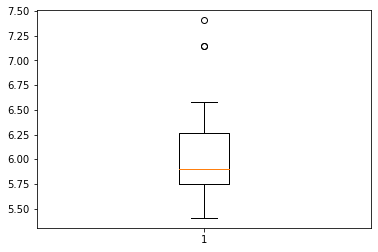

In [45]:
dir = "/Volumes/EVAN_DISK/Structured_data/misty_sarah_vaughan"
file_name_template = "audio_vocal_cropped"
aligned_audio = PraatScript_Lyric_Wrapper(os.path.join(dir, file_name_template+".wav"), 
                                         os.path.join(dir, file_name_template+".txt"))
strength = aligned_audio.pitch.selected_array["strength"]
frequency = aligned_audio.pitch.selected_array["frequency"]
frequency[strength < 0.5] = 0
frequency[frequency == 0] = np.nan
frequency_xs = aligned_audio.pitch.xs()

self = aligned_audio

# this function computes vibrato by analyzing the zero-crossing of the input frequency array
# if it can identify 3 zero crossing that are equally spaced apart, then it recognize those
# as a vibrato.
min_zero_crossing_distance = 1.0 / 19  # max vibrato frequency = 7 Hz = 14 zero crossings per second
self.tolerance = aligned_audio.dt * 4  # using the uncertainty of the instrument (pitch measuring device) to bound tolerance
dt = self.dt
# compute time derivative
d_frequency_dt = correlate(frequency, np.array([-1.0, 0, 1.0]), mode="same") / dt / 2

# obtain zero crossings
zero_crossing = []
for i in range(0, d_frequency_dt.shape[0] - 1):
    if (d_frequency_dt[i] < 0 and d_frequency_dt[i + 1] >= 0) or (
            d_frequency_dt[i] > 0 and d_frequency_dt[i + 1] <= 0):
        zero_crossing.append(i + 1)

# choose sets of zero crossing and identify vibratos within those
distance = 0
in_vibrato = 0
starting_time = -1
vibrato_intervals = []
vib_frequency = []
for i in range(0, len(zero_crossing) - 1):
    current_distance = frequency_xs[zero_crossing[i + 1]] - frequency_xs[zero_crossing[i]]

    if abs(current_distance - distance) <= self.tolerance and current_distance >= min_zero_crossing_distance:
        if in_vibrato == 0:
            starting_time = zero_crossing[i - 1]
            distance = (distance + current_distance) / 2  # calculate new average
            in_vibrato = 1
        elif in_vibrato > 0:
            distance = (distance * in_vibrato + current_distance) / (in_vibrato + 1)  # calculate new average
            in_vibrato = in_vibrato + 1
    else:
        if in_vibrato > 0:
            if in_vibrato > 3:
                if 1/distance/2 > 7:
                    print([frequency_xs[starting_time], frequency_xs[zero_crossing[i]]])
                vib_frequency.append(1/distance/2)
                vibrato_intervals.append([frequency_xs[starting_time], frequency_xs[zero_crossing[i]]])
            in_vibrato = 0
            distance = current_distance
        else:
            distance = current_distance
from matplotlib import pyplot as plt
plt.boxplot(vib_frequency)

# Testing code

In [1]:
from util.sound_processing import *


In [16]:
dir = "E:/Structured_data/rolling_in_the_deep_adele"
file_name_template = "audio"
lyric = combine_lyric_alignment_textgrids(dir, file_name_template)
lyric.compute_self_vibrato_intervals()
lyric.compute_self_pitch_intervals()
lyric.compute_self_singing_style_intervals()
lyric.write_textgrid(dir, file_name_template+"full")

TypeError: __init__() should return None, not 'type'

In [13]:
print(lyric.voice_quality_lists)

[[], [], [], ['head'], [], [], ['head'], [], ['head'], [], [], [], ['head'], [], [], ['head'], [], [], ['head'], [], [], [], [], ['head'], [], ['head'], [], [], ['head'], ['head'], [], [], ['head'], [], [], ['head'], [], [], [], [], ['head'], [], [], ['head'], [], [], [], ['head'], [], [], ['head'], [], [], [], ['head'], ['head'], [], ['head'], [], [], ['head'], [], [], [], ['head'], [], [], [], ['head'], ['head'], [], [], [], [], ['head'], ['head'], [], [], [], ['head'], [], [], [], ['head'], [], [], ['head'], [], [], [], ['head'], [], [], ['head'], [], [], ['head'], []]


In [12]:
for i in range(0, len(lyric.phoneme_list)):
    print(lyric.phoneme_list[i])
    print(lyric.phoneme_intervals[i])
        

EOS_tag
[0.0, 0.0]
>
[0.0840625, 0.1000625]
W
[0.1000625, 0.1320625]
IY
[0.1320625, 0.2920625]
>
[0.2920625, 0.3240625]
K
[0.3240625, 0.38754073689673074]
UH
[0.38754073689673074, 0.7107276855215362]
D
[0.7107276855215362, 0.7384294239750909]
AH
[0.7384294239750909, 0.8353855085625326]
V
[0.8353855085625326, 0.890788985469642]
>
[0.890788985469642, 0.9184907239231968]
HH
[0.9184907239231968, 0.9692772444213805]
AE
[0.9692772444213805, 1.269379411001557]
D
[1.269379411001557, 1.3109320186818891]
>
[1.3109320186818891, 1.3386337571354439]
IH
[1.3386337571354439, 1.4309728853139596]
T
[1.4309728853139596, 1.4817594058121433]
>
[1.4817594058121433, 1.578715490399585]
AO
[1.578715490399585, 4.4689302023871305]
L
[4.4689302023871305, 4.6600624999999996]
EOS_tag
[4.6600624999999996, 4.6600624999999996]
>
[4.962125, 5.2021250000000006]
R
[5.2021250000000006, 5.261602145940463]
OW
[5.261602145940463, 5.566773278647922]
L
[5.566773278647922, 5.607163575623909]
IH
[5.607163575623909, 5.8136028712

In [4]:
class Value_stat():
    def __init__(self, x : np.array, y : np.array):
        self.x = x
        self.y = y
        self.mean = y.mean()
        self.std = y.std()
        self.min = y.min()
        self.max = y.max()
        self.median = np.median(y)
        q = np.nanpercentile(y, [5, 95])
        self.min_2 = q[0]
        self.max_98 = q[1]
        
    def plot(self):
        plt.plot(self.x, np.ones(self.x.shape)*self.mean)
        plt.plot(self.x, self.y)
    def thresholding(self, threshold):
        self.y[self.y <= threshold] = np.nan
        mask = np.isnan(self.y) 
        self.y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), self.y[~mask])
        self.y = savgol_filter(self.y, 21, 3)
        self.y = interp1d(self.x, self.y, kind="linear")(self.x)
        
        self.mean = self.y.mean()
        self.std = self.y.std()
        self.min = self.y.min()
        self.max = self.y.max()
        self.median = y.median()

### Song 1

In [5]:
from util.SongDataStructure import *
from scipy.interpolate import interp1d
from numpy import correlate
from util.pitch_interval_estimation import *
lyric = Minimal_song_data_structure("E:\\MASC\\facial_data_analysis_videos\\1\\video_vocals.wav", " ")

In [6]:
song_I = Value_stat(lyric.intensity.xs(), lyric.intensity_arr[:, 0])
Intensity_interp = interp1d(lyric.intensity.xs(), savgol_filter(lyric.intensity_arr[:, 0], 21, 3))
pitch_interp = interp1d(lyric.pitch.xs(),  savgol_filter(lyric.pitch_arr, 21, 3))
formant_interp = interp1d(lyric.formant.xs(),  savgol_filter(lyric.formants_arr[:, 0], 21, 3))


In [7]:
interval = [19, 24]
interval_xs = np.arange(interval[0], interval[1], 0.01)

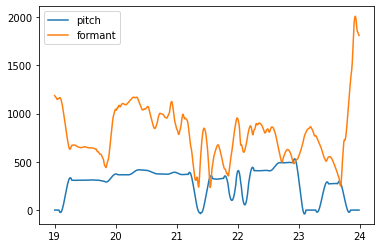

In [19]:
plt.plot(interval_xs, pitch_interp(interval_xs), label="pitch")
plt.plot(interval_xs, formant_interp(interval_xs), label="formant")
plt.legend()

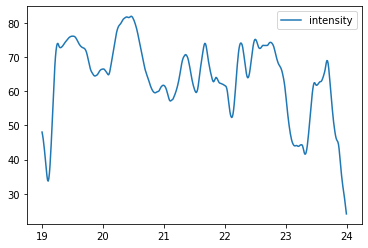

In [20]:
plt.plot(interval_xs, Intensity_interp(interval_xs), label="intensity")
plt.legend()

In [45]:
pitch_slope, pitch_interval = efficient_piece_wise_linear_intervals(interval_xs, pitch_interp(interval_xs))
I_slope, I_interval = efficient_piece_wise_linear_intervals(interval_xs, Intensity_interp(interval_xs))

In [54]:
def plot_piece_wise_lienar_intervals(xs, original_curve, intervals, slope):
    x = [interval_xs[intervals[0][0]]]
    y = [original_curve[intervals[0][0]]]
    for i in range(0, len(intervals)):
        x.append(interval_xs[intervals[i][1]])
        y.append(original_curve[intervals[i][1]])
    x = np.array(x)
    y = np.array(y)
    plt.plot(x, y, "o")
    plt.plot(interval_xs, original_curve)
    plt.show()


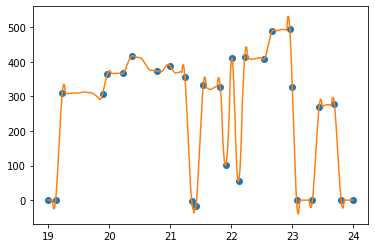

In [55]:
plot_piece_wise_lienar_intervals(interval_xs, pitch_interp(interval_xs), pitch_interval, pitch_slope)

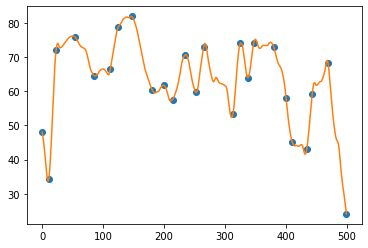

In [47]:
plot_piece_wise_lienar_intervals(Intensity_interp(interval_xs), I_interval, I_slope)

In [100]:
def increasing_filter(x, f, F, I):
    dt = 0.01
    fx = f(x)
    Fx = F(x)
    Ix = I(x)
    d_fx_dt = correlate(fx, np.array([-1.0, 0, 1.0]), mode="same") / dt / 2
    d_Fx_dt = correlate(Fx, np.array([-1.0, 0, 1.0]), mode="same") / dt / 2
    d_Ix_dt = correlate(Ix, np.array([-1.0, 0, 1.0]), mode="same") / dt / 2
    out_arr = np.zeros(Fx.shape)
    for i in range(0, x.shape[0]):
        if d_fx_dt[i] > 0 and d_Ix_dt[i] > 0:
            out_arr[i] = 1
    plt.plot(x, out_arr)
    return out_arr

In [102]:
def peak_neighbourhood_filter(x, f):
    dt = x[1] - x[0]
    fx = f(x)
    d_fx_dt = correlate(fx, np.array([-1.0, 0, 1.0]), mode="same") / dt / 2
    max_i = numpy.argmax(fx)
    mask = np.zeros(fx.shape)
    # look to the left of max_i
    # try stop looking either at zero crossing or 
    for i in range(1, max_i):
        index = max_i - i
        
        

SyntaxError: invalid syntax (Temp/ipykernel_16800/1896633140.py, line 8)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 0., 0., 0., 0.

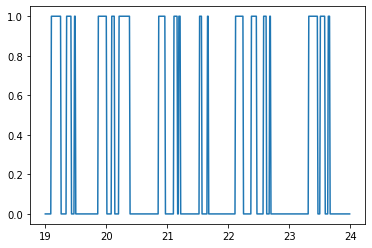

In [101]:
increasing_filter(interval_xs, pitch_interp, formant_interp, Intensity_interp)